In [35]:
#from models.nalu import NALU
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn')

In [36]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from models.nac import NeuralAccumulatorCell
from torch.nn.parameter import Parameter


import random
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from torch.nn.parameter import Parameter



class NeuralArithmeticLogicUnitCell(nn.Module):
    """A Neural Arithmetic Logic Unit (NALU) cell [1].
    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.
    Sources:
        [1]: https://arxiv.org/abs/1808.00508
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.nac = NeuralAccumulatorCell(in_dim, out_dim)
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.G, a=math.sqrt(5))

    def forward(self, input):
        a = self.nac(input)
        g = torch.sigmoid(F.linear(input, self.G, self.bias))
        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.nac(log_input))
        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y

    def extra_repr(self):
        return 'in_dim={}, out_dim={}'.format(
            self.in_dim, self.out_dim
        )


class NALU(nn.Module):
    """A stack of NAC layers.
    Attributes:
        num_layers: the number of NAC layers.
        in_dim: the size of the input sample.
        hidden_dim: the size of the hidden layers.
        out_dim: the size of the output.
    """
    def __init__(self, num_layers, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.num_layers = num_layers
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        layers = []
        for i in range(num_layers):
            layers.append(
                NeuralArithmeticLogicUnitCell(
                    hidden_dim if i > 0 else in_dim,
                    hidden_dim if i < num_layers - 1 else out_dim,
                )
            )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

In [37]:
def generate_synthetic_arithmetic_dataset(arithmetic_op, min_value, max_value, sample_size, set_size, boundaries = None):
    """
    generates a dataset of integers for the synthetics arithmetic task
    :param arithmetic_op: the type of operation to perform on the sum of the two sub sections can be either :
    ["add" , "subtract", "multiply", "divide", "root", "square"]
    :param min_value: the minimum possible value of the generated integers
    :param max_value: the maximum possible value of the generated integers
    :param sample_size: the number of integers per sample
    :param set_size: the number of samples in the dataset
    :param boundaries: [Optional] an iterable of 4 integer indices in the following format :
    [start of 1st section, end of 1st section, start of 2nd section, end of 2nd section]
    if None, the boundaries are randomly generated.
    :return: the training dataset input, the training true outputs, the boundaries of the sub sections used
    """
    scaled_input_values = np.random.randint(min_value, max_value, (set_size, sample_size))

    if boundaries is None:
        boundaries = [np.random.randint(sample_size) for i in range(4)]
        boundaries[1] = np.random.randint(boundaries[0], sample_size)
        boundaries[3] = np.random.randint(boundaries[2], sample_size)
    else:
        if len(boundaries) != 4:
            raise ValueError("boundaries is expected to be a list of 4 elements but found {}".format(len(boundaries)))

    a = np.array([np.sum(sample[boundaries[0]:boundaries[1]]) for sample in scaled_input_values])
    b = np.array([np.sum(sample[boundaries[2]:boundaries[3]]) for sample in scaled_input_values])
    true_outputs = None
    if "add" in str.lower(arithmetic_op):
        true_outputs = a + b
    elif "sub" in str.lower(arithmetic_op):
        true_outputs = a - b
    elif "mult" in str.lower(arithmetic_op):
        true_outputs = a * b
    elif "div" in str.lower(arithmetic_op):
        true_outputs = a / b
    elif "square" == str.lower(arithmetic_op):
        true_outputs = a * a
    elif "root" in str.lower(arithmetic_op):
        true_outputs = np.sqrt(a)

    return scaled_input_values, true_outputs, boundaries

In [74]:
EPOCHS = 100
LEARNING_RATE = 0.01
FEATURES_NUM = 10
batch_size = 12800 # or whatever

X_train, y_train, boundaries = generate_synthetic_arithmetic_dataset("add", -1000, 1000, FEATURES_NUM, 100000)
X_test, y_test, _ = generate_synthetic_arithmetic_dataset("add", -10000, 10000, FEATURES_NUM, 100000, boundaries)

print("Training size: ", np.shape(X_train), np.shape(y_train))
print("Test size:", np.shape(X_test), np.shape(y_test))

print("Training X min and max: ", np.min(X_train),np.max(X_train))
print("Training y min and max: ", np.min(y_train),np.max(y_train))

print("Test X min and max: ", np.min(X_test),np.max(X_test))
print("Test y min and max: ", np.min(y_test),np.max(y_test))

print("Boundaries: ", boundaries)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).unsqueeze(1)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).unsqueeze(1)



Training size:  (100000, 10) (100000,)
Test size: (100000, 10) (100000,)
Training X min and max:  -1000 999
Training y min and max:  -3992 3988
Test X min and max:  -10000 9999
Test y min and max:  -39800 39820
Boundaries:  [5, 7, 5, 7]


In [75]:
in_dim = 10
hidden_dim = 2
out_dim = 1
num_layers = 2

net = NALU(num_layers, in_dim, hidden_dim, out_dim)
optim = torch.optim.RMSprop(net.parameters(),lr=LEARNING_RATE)
print(net)

NALU(
  (model): Sequential(
    (0): NeuralArithmeticLogicUnitCell(
      in_dim=10, out_dim=2
      (nac): NeuralAccumulatorCell(in_dim=10, out_dim=2)
    )
    (1): NeuralArithmeticLogicUnitCell(
      in_dim=2, out_dim=1
      (nac): NeuralAccumulatorCell(in_dim=2, out_dim=1)
    )
  )
)


In [70]:
def training(model, data, target, optimizer):
    
    training_loss = []
    for epoch in range(EPOCHS):
        
        permutation = torch.randperm(data.size()[0])
        for i in range(0,data.size()[0], batch_size):
            optimizer.zero_grad()
            
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = data[indices], target[indices]
                
            out = model(batch_x)

            loss = F.mse_loss(out, batch_y)
            training_loss.append(loss)
        
            loss.backward()
            optimizer.step()
        
    return training_loss

In [71]:
def test(model, data, target):
    with torch.no_grad():
        out = model(data)
        return torch.abs(target - out)

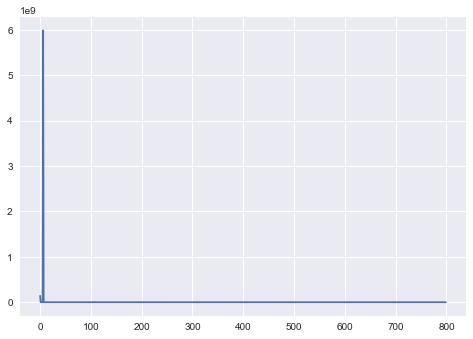

In [76]:
loss = training(net, X_train, y_train, optim)
plt.plot(loss)

In [77]:
loss[-1]

tensor(1.00000e+06 *
       2.4618)

In [ ]:


test(net, X_test, y_test)